In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import math
import numpy as np
import matplotlib.pyplot as plt

import json
import pandas as pd

from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    mean_absolute_error, 
    median_absolute_error, 
    explained_variance_score
)
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, Dense, Dropout, GlobalAveragePooling1D,
                                    MultiHeadAttention, LayerNormalization, Add, Concatenate)
from tensorflow.keras.models import Model
import keras_tuner as kt

from geexhp import datavis as dvis
dvis.configure_matplotlib()

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [2]:
with open('normalization_stats.json') as f:
    stats = json.load(f)

input_stats = {
    'UV': (stats['inputs']['UV']['mean'], stats['inputs']['UV']['std']),
    'Vis': (stats['inputs']['Vis']['mean'], stats['inputs']['Vis']['std']),
    'NIR': (stats['inputs']['NIR']['mean'], stats['inputs']['NIR']['std'])
}

output_stats = {
    key: (stats['outputs'][key]['mean'], stats['outputs'][key]['std'])
    for key in stats['outputs']
}

In [3]:
def parse_example(example_proto, input_stats, output_stats):
    raw_input_features = {
        'NOISY_ALBEDO_B-NIR': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-UV': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-Vis': tf.io.VarLenFeature(tf.float32),
    }

    raw_output_features = {
        "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
        "OBJECT-GRAVITY": tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-TEMPERATURE": tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-PRESSURE": tf.io.FixedLenFeature([], tf.float32),

        # 'Earth_type' : tf.io.FixedLenFeature([], tf.string),

        'log_C2H6': tf.io.FixedLenFeature([], tf.float32),
        'log_CH4': tf.io.FixedLenFeature([], tf.float32),
        'log_CO': tf.io.FixedLenFeature([], tf.float32),
        'log_CO2': tf.io.FixedLenFeature([], tf.float32),
        'log_H2O': tf.io.FixedLenFeature([], tf.float32),
        'log_N2': tf.io.FixedLenFeature([], tf.float32),
        'log_N2O': tf.io.FixedLenFeature([], tf.float32),
        'log_O2': tf.io.FixedLenFeature([], tf.float32),
        'log_O3': tf.io.FixedLenFeature([], tf.float32)
    }

    all_features = {**raw_input_features, **raw_output_features}
    parsed = tf.io.parse_single_example(example_proto, all_features)

    # ----------------------
    # Input Normalization
    # ----------------------
    normalized_inputs = {}
    for region in ['UV', 'Vis', 'NIR']:
        # Get raw spectrum
        spectrum = parsed[f'NOISY_ALBEDO_B-{region}']
        if isinstance(spectrum, tf.SparseTensor):
            spectrum = tf.sparse.to_dense(spectrum, default_value=0.0)
        
        # Normalize using dataset statistics
        mean = input_stats[region][0]
        std = input_stats[region][1]
        normalized = (spectrum - mean) / std
        
        # Reshape to appropriate dimensions
        if region == 'UV':
            normalized = tf.reshape(normalized, [8, 1])
        elif region == 'Vis':
            normalized = tf.reshape(normalized, [94, 1])
        elif region == 'NIR':
            normalized = tf.reshape(normalized, [49, 1])
            
        normalized_inputs[f'NOISY_ALBEDO_B-{region}'] = normalized

    # ----------------------
    # Output Processing
    # ----------------------
    processed_outputs = {}
    
    radius = parsed['OBJECT-RADIUS-REL-EARTH']
    processed_outputs['OBJECT-RADIUS-REL-EARTH'] = (radius - output_stats['OBJECT-RADIUS-REL-EARTH'][0]) / output_stats['OBJECT-RADIUS-REL-EARTH'][1]
    
    gravity = parsed['OBJECT-GRAVITY']
    processed_outputs['OBJECT-GRAVITY'] = (gravity - output_stats['OBJECT-GRAVITY'][0]) / output_stats['OBJECT-GRAVITY'][1]
    
    temperature = parsed['ATMOSPHERE-TEMPERATURE']
    processed_outputs['ATMOSPHERE-TEMPERATURE'] = (temperature - output_stats['ATMOSPHERE-TEMPERATURE'][0]) / output_stats['ATMOSPHERE-TEMPERATURE'][1]
    
    pressure = parsed['ATMOSPHERE-PRESSURE']
    processed_outputs['ATMOSPHERE-PRESSURE'] = (pressure - output_stats['ATMOSPHERE-PRESSURE'][0]) / output_stats['ATMOSPHERE-PRESSURE'][1]
    
    for chem in ['log_C2H6', 'log_CH4', 'log_CO', 'log_CO2', 'log_H2O', 'log_N2', 'log_N2O', 'log_O2', 'log_O3']:
        chem_value = parsed[chem]
        processed_outputs[f'{chem}'] = (chem_value - output_stats[f'{chem}'][0]) /  output_stats[f'{chem}'][1]

    # processed_outputs['Earth_type'] = parsed['Earth_type']
    # processed_outputs["NOISE_B-NIR"] = parsed["NOISE_B-NIR"]

    return normalized_inputs, processed_outputs

In [4]:
def read_tfrecord(file_path, input_stats, output_stats, 
                    batch_size=256, shuffle_buffer=None, repeat=False):
    
    dataset = tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE)

    if shuffle_buffer is not None and shuffle_buffer > 0:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    # Parse the dataset after shuffling
    parsed_dataset = dataset.map(
        lambda x: parse_example(x, input_stats, output_stats), 
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Repeat the dataset for multiple epochs
    if repeat:
        parsed_dataset = parsed_dataset.repeat()

    # Batch after shuffling and parsing
    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)
    
    return parsed_dataset

In [5]:
train_ds = read_tfrecord("../data/train.tfrecord", input_stats, output_stats, shuffle_buffer=700000, repeat=True)
val_ds = read_tfrecord("../data/val.tfrecord", input_stats, output_stats, shuffle_buffer=50000)
test_ds = read_tfrecord("../data/test.tfrecord", input_stats, output_stats)

In [6]:
batch = next(iter(train_ds.take(1)))

print("\n## Input Shapes:")
for k,v in batch[0].items():
    print(f"> {k}: {v.shape}") 

print("\n## Output Ranges (standardized):")
for k,v in batch[1].items():
    if k != 'Earth_type':
        print(f"> {k}: {tf.reduce_mean(v):.3f} ± {tf.math.reduce_std(v):.6f}")


## Input Shapes:
> NOISY_ALBEDO_B-UV: (256, 8, 1)
> NOISY_ALBEDO_B-Vis: (256, 94, 1)
> NOISY_ALBEDO_B-NIR: (256, 49, 1)

## Output Ranges (standardized):
> OBJECT-RADIUS-REL-EARTH: 0.005 ± 1.038056
> OBJECT-GRAVITY: 0.008 ± 1.030694
> ATMOSPHERE-TEMPERATURE: 0.065 ± 0.979470
> ATMOSPHERE-PRESSURE: 0.016 ± 1.015681
> log_C2H6: 0.178 ± 0.914682
> log_CH4: -0.043 ± 1.003739
> log_CO: -0.154 ± 0.990650
> log_CO2: -0.017 ± 1.022051
> log_H2O: 0.112 ± 0.976136
> log_N2: 0.003 ± 0.931936
> log_N2O: -0.189 ± 0.940964
> log_O2: -0.152 ± 1.019632
> log_O3: -0.193 ± 0.943757


In [7]:
def plot_spectrum(ds, sample_number):
    for batch in ds.take(1):
        pass

    x1 = batch[0]['NOISY_ALBEDO_B-UV'][sample_number]
    x2 = batch[0]['NOISY_ALBEDO_B-Vis'][sample_number]
    x3 = batch[0]['NOISY_ALBEDO_B-NIR'][sample_number]

    UV = np.array([0.2       , 0.22857143, 0.26122449, 0.29854227, 0.34119117,
       0.38993277, 0.44563745, 0.50929994])
    VIS = np.array([0.515     , 0.51867857, 0.52238342, 0.52611473, 0.52987269,
       0.5336575 , 0.53746934, 0.5413084 , 0.54517489, 0.549069  ,
       0.55299092, 0.55694085, 0.560919  , 0.56492557, 0.56896075,
       0.57302475, 0.57711779, 0.58124006, 0.58539177, 0.58957314,
       0.59378438, 0.5980257 , 0.60229731, 0.60659943, 0.61093229,
       0.61529609, 0.61969106, 0.62411742, 0.62857541, 0.63306523,
       0.63758712, 0.64214132, 0.64672804, 0.65134753, 0.65600001,
       0.66068572, 0.66540491, 0.6701578 , 0.67494464, 0.67976568,
       0.68462114, 0.6895113 , 0.69443638, 0.69939664, 0.70439233,
       0.7094237 , 0.71449101, 0.71959452, 0.72473448, 0.72991116,
       0.73512481, 0.7403757 , 0.7456641 , 0.75099027, 0.75635448,
       0.76175702, 0.76719814, 0.77267812, 0.77819725, 0.78375581,
       0.78935406, 0.7949923 , 0.80067082, 0.8063899 , 0.81214983,
       0.8179509 , 0.8237934 , 0.82967764, 0.83560391, 0.84157251,
       0.84758374, 0.85363791, 0.85973532, 0.86587629, 0.87206112,
       0.87829013, 0.88456363, 0.89088194, 0.89724539, 0.90365428,
       0.91010895, 0.91660973, 0.92315694, 0.92975092, 0.936392  ,
       0.94308052, 0.9498168 , 0.95660121, 0.96343408, 0.97031575,
       0.97724657, 0.98422691, 0.9912571 , 0.99833751])
    NIR = np.array([1.01      , 1.02442857, 1.03906327, 1.05390703, 1.06896284,
       1.08423374, 1.09972279, 1.11543312, 1.13136788, 1.14753028,
       1.16392356, 1.18055104, 1.19741606, 1.214522  , 1.23187232,
       1.24947049, 1.26732007, 1.28542464, 1.30378785, 1.32241339,
       1.34130501, 1.36046651, 1.37990175, 1.39961463, 1.41960913,
       1.43988926, 1.4604591 , 1.48132281, 1.50248456, 1.52394862,
       1.54571932, 1.56780102, 1.59019818, 1.6129153 , 1.63595694,
       1.65932776, 1.68303244, 1.70707576, 1.73146256, 1.75619774,
       1.78128628, 1.80673322, 1.8325437 , 1.85872289, 1.88527608,
       1.91220859, 1.93952586, 1.96723337, 1.9953367 ])

    plt.plot(UV, x1, label='UV')
    plt.plot(VIS, x2, label='Vis')
    plt.plot(NIR, x3, label='NIR')
    plt.legend()
    plt.show()

    for output in batch[1].keys():
        print(f'> {output}: \t {batch[1][output][sample_number]}')

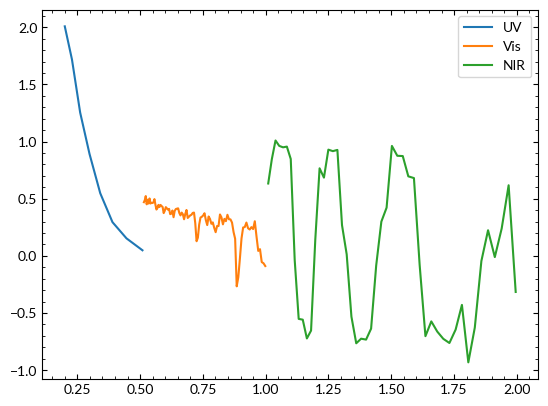

> OBJECT-RADIUS-REL-EARTH: 	 0.09335675090551376
> OBJECT-GRAVITY: 	 0.03265159949660301
> ATMOSPHERE-TEMPERATURE: 	 2.2145369052886963
> ATMOSPHERE-PRESSURE: 	 -0.09957317262887955
> log_C2H6: 	 -1.7026677131652832
> log_CH4: 	 0.6840556263923645
> log_CO: 	 0.8814743161201477
> log_CO2: 	 -0.7638277411460876
> log_H2O: 	 -1.4936398267745972
> log_N2: 	 0.5027275681495667
> log_N2O: 	 1.371329665184021
> log_O2: 	 0.9238318204879761
> log_O3: 	 1.3605650663375854


In [8]:
plot_spectrum(train_ds, 0)

In [9]:
TRAIN_SAMPLES = 779887
VAL_SAMPLES = 66676
BATCH_SIZE = 256

steps_per_epoch = math.ceil(TRAIN_SAMPLES / BATCH_SIZE)
validation_steps = math.ceil(VAL_SAMPLES / BATCH_SIZE)

In [10]:
def transformer_block(x, num_heads, ff_dim, dropout_rate, activation):
    # Multi-Head Self-Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = Add()([x, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)
    
    # Feed-forward network
    ffn = Dense(ff_dim, activation=activation)(out1)
    ffn = Dense(x.shape[-1])(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    out2 = Add()([out1, ffn])
    out2 = LayerNormalization(epsilon=1e-6)(out2)
    return out2

In [11]:
def build_model(hp):
    # ------------------------------------------------
    # Convolutional Hyperparameters
    # ------------------------------------------------
    conv_filters = hp.Int('conv_filters', min_value=16, max_value=64, step=16, default=32)
    conv_kernel  = hp.Choice('conv_kernel', values=[3, 5])
    conv_layers  = hp.Int('conv_layers', min_value=1, max_value=3, default=2)
    
    # ------------------------------------------------
    # Transformer Hyperparameters
    # ------------------------------------------------
    transformer_blocks = hp.Int('transformer_blocks', min_value=1, max_value=3, default=2)
    num_heads          = hp.Choice('num_heads', values=[2, 4, 8])
    ff_dim             = hp.Int('ff_dim', min_value=16, max_value=64, step=16, default=32)
    
    # ------------------------------------------------
    # Regularization and Dense Hyperparameters
    # ------------------------------------------------
    dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])
    dense_units  = hp.Int('dense_units', min_value=64, max_value=256, step=64, default=128)
    lr           = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    l2_reg       = hp.Float('l2_reg', 1e-5, 1e-3, sampling='log')
    
    # ------------------------------------------------
    # Hidden Activation (avoiding ReLU so negatives are possible)
    # ------------------------------------------------
    hidden_activation = hp.Choice('hidden_activation', values=['swish', 'elu'], default='swish')
    
    # ------------------------------------------------
    # Loss Weight Hyperparameters for log_O2 and log_O3
    # ------------------------------------------------
    log_o2_weight = hp.Float('log_o2_weight', min_value=1.0, max_value=5.0, step=0.5, default=3.0)
    log_o3_weight = hp.Float('log_o3_weight', min_value=1.0, max_value=5.0, step=0.5, default=3.0)
    
    # ------------------------------------------------
    # Helper: Build a hybrid branch that uses Conv1D followed by Transformer blocks.
    # ------------------------------------------------
    def build_branch(input_tensor, conv_layers_count):
        x = input_tensor
        # Convolutional embedding with the chosen hidden activation.
        for i in range(conv_layers_count):
            x = Conv1D(filters=conv_filters,
                       kernel_size=conv_kernel,
                       padding='same',
                       activation=hidden_activation,
                       kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
                      )(x)
        # Apply a series of Transformer encoder blocks.
        for _ in range(transformer_blocks):
            x = transformer_block(x, num_heads=num_heads, ff_dim=ff_dim,
                                  dropout_rate=dropout_rate, activation=hidden_activation)
        return GlobalAveragePooling1D()(x)
    
    # ------------------------------------------------
    # Input Layers for each spectral branch
    # ------------------------------------------------
    input_uv  = Input(shape=(8, 1), name='NOISY_ALBEDO_B-UV')
    input_vis = Input(shape=(94, 1), name='NOISY_ALBEDO_B-Vis')
    input_nir = Input(shape=(49, 1), name='NOISY_ALBEDO_B-NIR')
    
    # ------------------------------------------------
    # Build a branch for each input spectrum.
    # ------------------------------------------------
    branch_uv   = build_branch(input_uv, conv_layers)
    branch_vis  = build_branch(input_vis, conv_layers)
    branch_nir  = build_branch(input_nir, conv_layers)
    
    # Additionally, build a branch on concatenated inputs (to capture cross-spectral correlations).
    concat_input  = Concatenate(axis=1)([input_uv, input_vis, input_nir])
    branch_concat = build_branch(concat_input, conv_layers)
    
    # Merge all branches.
    merged = Concatenate()([branch_uv, branch_vis, branch_nir, branch_concat])
    
    # ------------------------------------------------
    # Dense Layers: using the chosen hidden activation.
    # ------------------------------------------------
    x = Dense(dense_units, activation=hidden_activation,
              kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(merged)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units // 2, activation=hidden_activation,
              kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    
    # ------------------------------------------------
    # Output Layers (13 regression targets, using linear activations)
    # ------------------------------------------------
    outputs_list = [
        "OBJECT-RADIUS-REL-EARTH",
        "OBJECT-GRAVITY",
        "ATMOSPHERE-TEMPERATURE",
        "ATMOSPHERE-PRESSURE",
        "log_C2H6",
        "log_CH4",
        "log_CO",
        "log_CO2",
        "log_H2O",
        "log_N2",
        "log_N2O",
        "log_O2",
        "log_O3"
    ]
    outputs = {}
    for name in outputs_list:
        outputs[name] = Dense(1, activation='linear', name=name)(x)
    
    # ------------------------------------------------
    # Build and Compile the Model
    # ------------------------------------------------
    model = Model(inputs=[input_uv, input_vis, input_nir], outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    # Define loss weights: give extra emphasis to log_O2 and log_O3 errors.
    loss_weights = {
        "OBJECT-RADIUS-REL-EARTH": 1.0,
        "OBJECT-GRAVITY": 1.0,
        "ATMOSPHERE-TEMPERATURE": 1.0,
        "ATMOSPHERE-PRESSURE": 1.0,
        "log_C2H6": 1.0,
        "log_CH4": 1.0,
        "log_CO": 1.0,
        "log_CO2": 1.0,
        "log_H2O": 1.0,
        "log_N2": 1.0,
        "log_N2O": 1.0,
        "log_O2": log_o2_weight,
        "log_O3": log_o3_weight
    }
    
    model.compile(optimizer=optimizer, loss='mae', loss_weights=loss_weights)
    return model


In [12]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=3,
    directory='opt',
    project_name='bayesopt'
)

Reloading Tuner from opt/bayesopt/tuner0.json


In [ ]:
tuner.search(train_ds, epochs=1, validation_data=val_ds, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

In [14]:
tuner.results_summary()

Results summary
Results in opt/bayesopt
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 01 summary
Hyperparameters:
conv_filters: 64
conv_kernel: 5
conv_layers: 3
transformer_blocks: 1
num_heads: 4
ff_dim: 48
dropout_rate: 0.2
dense_units: 128
learning_rate: 0.001
l2_reg: 7.671867010789075e-05
hidden_activation: swish
log_o2_weight: 1.5
log_o3_weight: 2.0
Score: 4.951295852661133

Trial 00 summary
Hyperparameters:
conv_filters: 32
conv_kernel: 5
conv_layers: 2
transformer_blocks: 1
num_heads: 4
ff_dim: 48
dropout_rate: 0.4
dense_units: 64
learning_rate: 0.01
l2_reg: 1.0353713140058703e-05
hidden_activation: swish
log_o2_weight: 1.5
log_o3_weight: 5.0
Score: 7.088889122009277

Trial 02 summary
Hyperparameters:
conv_filters: 48
conv_kernel: 3
conv_layers: 3
transformer_blocks: 2
num_heads: 4
ff_dim: 48
dropout_rate: 0.4
dense_units: 256
learning_rate: 0.01
l2_reg: 3.044249221201922e-05
hidden_activation: elu
log_o2_weight: 4.5
log_o3_weight: 4.5
Score: 16.004737

In [15]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hp.values)

Best Hyperparameters:
{'conv_filters': 64, 'conv_kernel': 5, 'conv_layers': 3, 'transformer_blocks': 1, 'num_heads': 4, 'ff_dim': 48, 'dropout_rate': 0.2, 'dense_units': 128, 'learning_rate': 0.001, 'l2_reg': 7.671867010789075e-05, 'hidden_activation': 'swish', 'log_o2_weight': 1.5, 'log_o3_weight': 2.0}


In [16]:
best_model = build_model(best_hp)

In [17]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ NOISY_ALBEDO_B-UV   │ (None, 8, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOISY_ALBEDO_B-Vis  │ (None, 94, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOISY_ALBEDO_B-NIR  │ (None, 49, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 151, 1)    │          0 │ NOISY_ALBEDO_B-U… │
│ (Concatenate)       │                   │            │ NOISY_ALBEDO_B-V… │
│                     │                   │            │ NOISY_ALBEDO_B-N… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8, 64)     │        384 │ NOISY_ALBEDO_B-U… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 94, 64)    │        384 │ NOISY_ALBEDO_B-V… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 49, 64)    │        384 │ NOISY_ALBEDO_B-N… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 151, 64)   │        384 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 8, 64)     │     20,544 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 94, 64)    │     20,544 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 49, 64)    │     20,544 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 151, 64)   │     20,544 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 8, 64)     │     20,544 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 94, 64)    │     20,544 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 49, 64)    │     20,544 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 151, 64)   │     20,544 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 64)     │     49,792 │ conv1d_2[0][0],   │
│ (MultiHeadAttentio… │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 94, 64)    │     49,792 │ conv1d_5[0][0],   │
│ (MultiHeadAttentio… │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     49,792 │ conv1d_8[0][0],   │
│ (MultiHeadAttentio… │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 151, 64)   │     49,792 │ conv1d_11[0][0],  │
│ (MultiHeadAttentio… │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 433,101 (1.65 MB)

 Trainable params: 433,101 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/10
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 3264s 1s/step - ATMOSPHERE-PRESSURE_loss: 0.5716 - ATMOSPHERE-TEMPERATURE_loss: 0.7281 - OBJECT-GRAVITY_loss: 0.5651 - OBJECT-RADIUS-REL-EARTH_loss: 0.5631 - log_C2H6_loss: 0.2828 - log_CH4_loss: 0.4408 - log_CO2_loss: 0.6068 - log_CO_loss: 0.5249 - log_H2O_loss: 0.5208 - log_N2O_loss: 0.3303 - log_N2_loss: 0.4408 - log_O2_loss: 0.7434 - log_O3_loss: 0.5812 - loss: 6.9628 - val_ATMOSPHERE-PRESSURE_loss: 0.3828 - val_ATMOSPHERE-TEMPERATURE_loss: 0.6339 - val_OBJECT-GRAVITY_loss: 0.3786 - val_OBJECT-RADIUS-REL-EARTH_loss: 0.3761 - val_log_C2H6_loss: 0.1718 - val_log_CH4_loss: 0.3123 - val_log_CO2_loss: 0.5082 - val_log_CO_loss: 0.4733 - val_log_H2O_loss: 0.3601 - val_log_N2O_loss: 0.2032 - val_log_N2_loss: 0.3636 - val_log_O2_loss: 0.4621 - val_log_O3_loss: 0.2761 - val_loss: 4.9727
Epoch 2/10
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 3149s 1s/step - ATMOSPHERE-PRESSURE_loss: 0.4031 - ATMOSPHERE-TEMPERATURE_loss: 0.6444 - OBJECT-GRAVITY_loss: 0.3973 - OBJEC

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3047/3047 ━━━━━━━━━━━━━━━━━━━━ 3245s 1s/step - ATMOSPHERE-PRESSURE_loss: 0.3814 - ATMOSPHERE-TEMPERATURE_loss: 0.6246 - OBJECT-GRAVITY_loss: 0.3762 - OBJECT-RADIUS-REL-EARTH_loss: 0.3734 - log_C2H6_loss: 0.1971 - log_CH4_loss: 0.3246 - log_CO2_loss: 0.4956 - log_CO_loss: 0.4766 - log_H2O_loss: 0.3701 - log_N2O_loss: 0.2444 - log_N2_loss: 0.3304 - log_O2_loss: 0.5194 - log_O3_loss: 0.3895 - loss: 5.1783 - val_ATMOSPHERE-PRESSURE_loss: 0.3620 - val_ATMOSPHERE-TEMPERATURE_loss: 0.6136 - val_OBJECT-GRAVITY_loss: 0.3560 - val_OBJECT-RADIUS-REL-EARTH_loss: 0.3533 - val_log_C2H6_loss: 0.1541 - val_log_CH4_loss: 0.2934 - val_log_CO2_loss: 0.4643 - val_log_CO_loss: 0.4648 - val_log_H2O_loss: 0.3296 - val_log_N2O_loss: 0.1965 - val_log_N2_loss: 0.3264 - val_log_O2_loss: 0.4117 - val_log_O3_loss: 0.2555 - val_loss: 4.6580
Epoch 4/10
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 3098s 1s/step - ATMOSPHERE-PRESSURE_loss: 0.3707 - ATMOSPHERE-TEMPERATURE_loss: 0.6167 - OBJECT-GRAVITY_loss: 0.3660 - OBJECT-RADIUS-RE

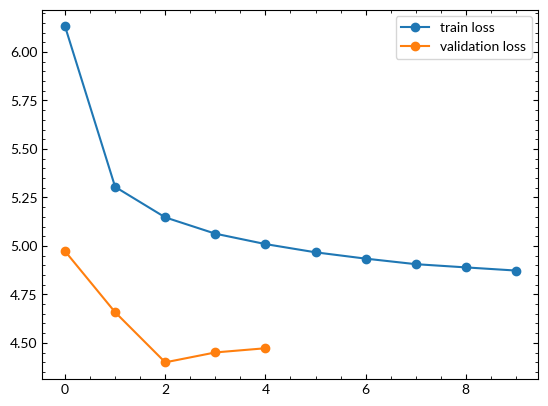

In [21]:
plt.plot(range(10), history.history["loss"], marker="o", label="train loss")
plt.plot(range(5), history.history["val_loss"], marker="o", label="validation loss")
plt.legend();

In [22]:
predictions = best_model.predict(test_ds)

368/368 ━━━━━━━━━━━━━━━━━━━━ 120s 323ms/step


In [23]:
all_true = {key: [] for key in output_stats.keys()}
for batch_in, batch_out in test_ds:
    for key in output_stats:
        all_true[key].append(batch_out[key].numpy())
for key in all_true:
    all_true[key] = np.concatenate(all_true[key], axis=0)

In [24]:
denorm_pred = {}
denorm_true = {}
for key in output_stats:
    mean_val = output_stats[key][0]
    std_val  = output_stats[key][1]

    y_pred_norm = predictions[key].reshape(-1)
    y_true_norm = all_true[key].reshape(-1)
    
    denorm_pred[key] = y_pred_norm * std_val + mean_val
    denorm_true[key] = y_true_norm * std_val + mean_val

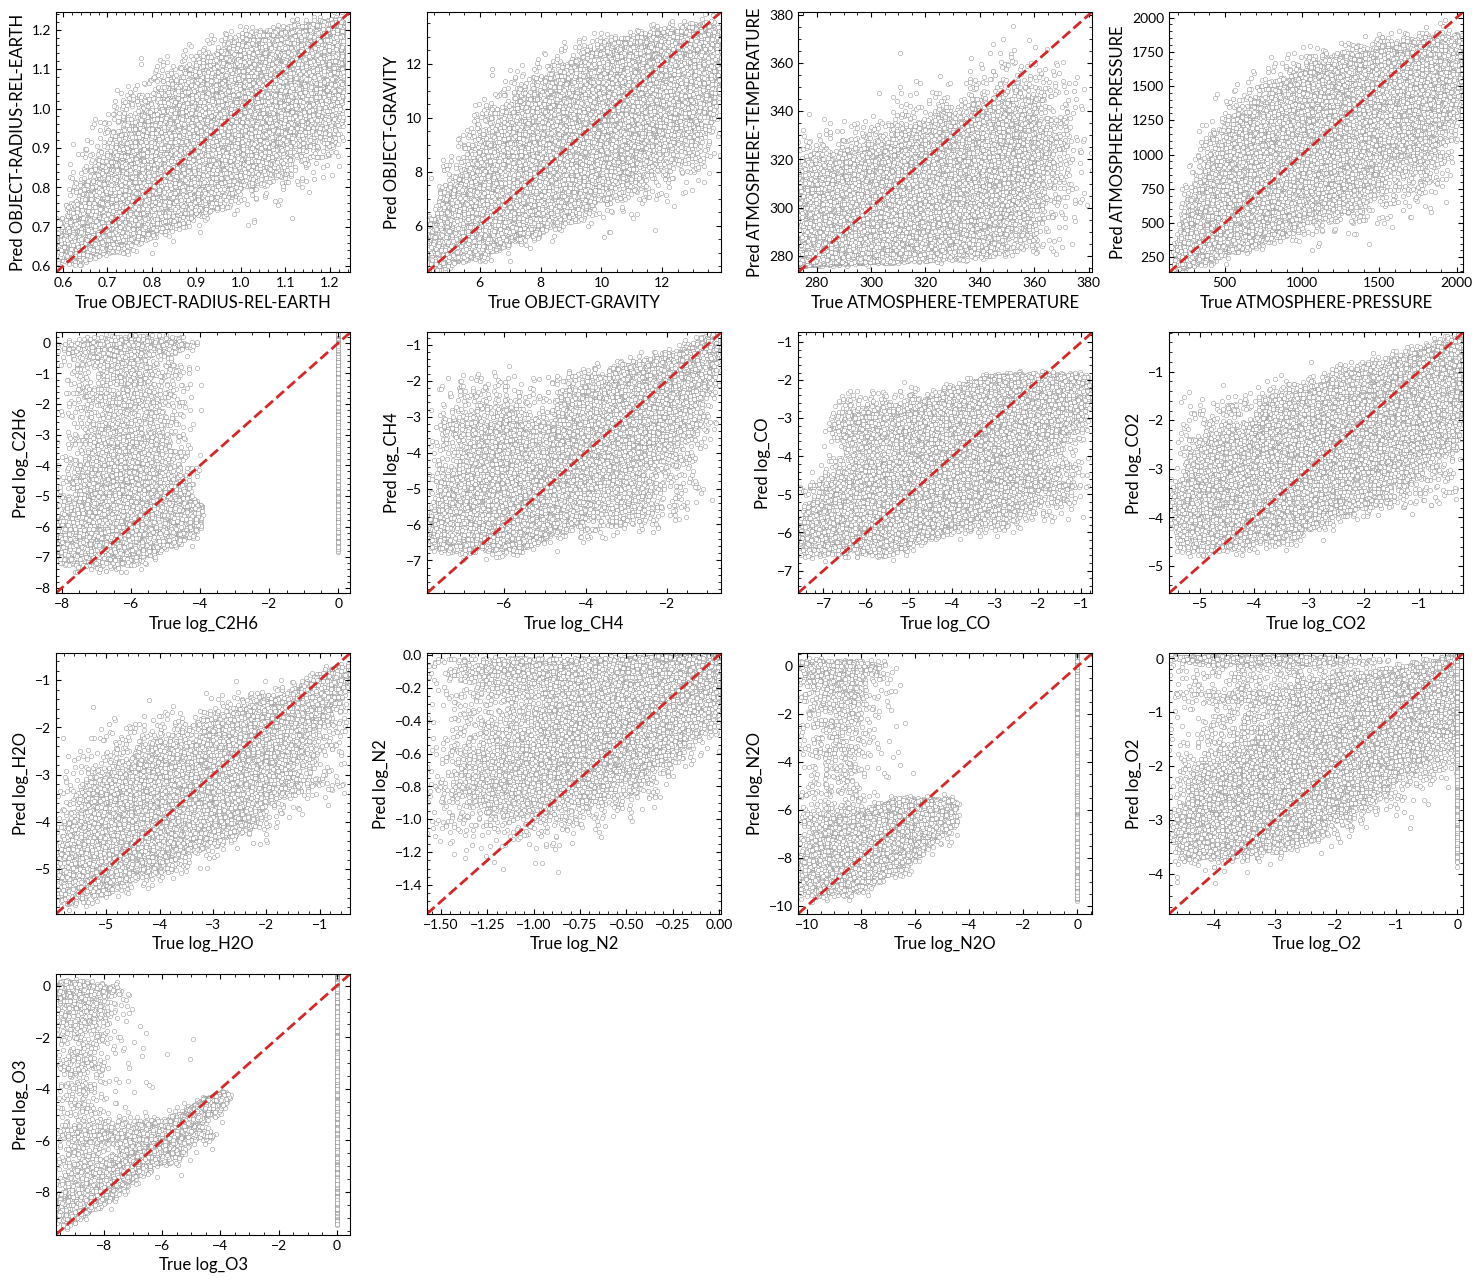

In [25]:
n_keys = len(output_stats.keys())
n_cols = 4  
n_rows = int(np.ceil(n_keys / n_cols)) 

plt.figure(figsize=(15, 13)) 
plt.subplots_adjust(wspace=0.3, hspace=0.4) 

for idx, key in enumerate(output_stats.keys(), 1):
    ax = plt.subplot(n_rows, n_cols, idx)
    
    ax.scatter(denorm_true[key], denorm_pred[key], s=10, edgecolor="gray", color="white", linewidth=0.3)
    
    min_val = min(denorm_true[key].min(), denorm_pred[key].min())
    max_val = max(denorm_true[key].max(), denorm_pred[key].max())
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)
    ax.set(xlim=(min_val, max_val), ylim=(min_val, max_val))
    
    ax.set_xlabel(f"True {key}")
    ax.set_ylabel(f"Pred {key}")
    
for idx in range(n_keys+1, n_rows*n_cols+1):
    plt.subplot(n_rows, n_cols, idx).axis('off')

plt.tight_layout();

In [26]:
metrics_list = []

for key in output_stats:
    y_true = denorm_true[key]
    y_pred = denorm_pred[key]
    
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    med_ae = median_absolute_error(y_true, y_pred)
    exp_var = explained_variance_score(y_true, y_pred)
    
    metrics_list.append({
        "Output": key,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

df_metrics = pd.DataFrame(metrics_list)
df_metrics

,Output,R²,Explained Variance,MSE,RMSE,MAE,Median Absolute Error
0,OBJECT-RADIUS-REL-EARTH,0.843822,0.845058,0.004255,0.065234,0.049132,0.037885
1,OBJECT-GRAVITY,0.840363,0.841523,0.979854,0.989876,0.741807,0.566117
2,ATMOSPHERE-TEMPERATURE,0.394019,0.437900,250.524368,15.827962,11.448151,7.774094
3,ATMOSPHERE-PRESSURE,0.828188,0.829896,40906.453125,202.253433,146.661499,104.472900
4,log_C2H6,0.855507,0.855570,1.209557,1.099799,0.447828,0.098305
5,log_CH4,0.840419,0.848928,0.496509,0.704634,0.485897,0.327103
6,log_CO,0.679671,0.679843,0.693937,0.833029,0.661517,0.576606
7,log_CO2,0.677576,0.681423,0.422063,0.649663,0.493970,0.383541
8,log_H2O,0.801775,0.801864,0.204363,0.452065,0.312965,0.209262
9,log_N2,0.554761,0.574185,0.023032,0.151762,0.064569,0.015377
